In [101]:
import torch
from torch import nn
from torch.nn.parameter import Parameter
import numpy as np 
import time
import os 
import matplotlib.pyplot as plt
from HPO.utils.model import NetworkMain
from HPO.utils.DARTS_utils import config_space_2_DARTS
from HPO.utils.FCN import FCN 
import pandas as pd
import torch
from HPO.data.teps_datasets import Train_TEPS , Test_TEPS
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader, SubsetRandomSampler
import random
import HPO.utils.augmentation as aug
from HPO.utils.train_utils import collate_fn_padd
from HPO.utils.train import train_model, auto_train_model
from HPO.utils.weight_freezing import freeze_FCN, freeze_resnet
from HPO.utils.ResNet1d import resnet18
from HPO.utils.files import save_obj
from queue import Empty
from sklearn.model_selection import StratifiedKFold as KFold
from collections import namedtuple
from HPO.utils.worker_score import Evaluator 
from HPO.utils.worker_utils import LivePlot
import seaborn as sns


In [102]:
PATH = "/home/cmackinnon/scripts/HPO/"


In [188]:
import csv 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns


def load(FILENAME):
    scores = []
    recall = []
    config = []

    with open( "{}{}".format(PATH,FILENAME) , newline = "") as csvfile:
        reader = csv.reader(csvfile, delimiter = ",")
        for row in reader:
            scores.append(float(row[0]))
            recall.append(float(row[1]))
            config.append(eval("".join(row[2:])))
    error = [1-x for x in scores]
    e_min = 1
    best_list = []
    for i in error:
      if i < e_min:
        e_min = i
      best_list.append(e_min)
    return {"scores":scores,"recall":recall,"config":config,"error":error,"best":best_list }

ss_1 = load("TEPS_new_ss.csv")
ss_2 = load("TEPS_SE_test.csv")
ss_3 = load("TEPS_concat_test.csv")
ss_4 = load("TEPS_attention_test.csv")
ss_5 = load("TEPS_attention_2_test.csv")


    
plt.figure(figsize = (19,10))
#plt.ylim(0.05,0.15)

plt.plot(ss_1["best"], label = "Original")
plt.plot(ss_2["best"], label = "Squeeze Excite")
plt.plot(ss_3["best"], label = "8 nodes")
plt.plot(ss_4["best"], label = "attention")
plt.plot(ss_5["best"], label = "attention_2")
plt.legend()

In [195]:
def report(s):
    mu = np.mean(s)
    std = np.std(s)
    print("Mean: {} -- StandardD: {}".format(mu,std))

s = ss_1["scores"]
report(s)
s = ss_2["scores"]
report(s)
s = ss_3["scores"]
report(s)
s = ss_4["scores"]
report(s)
s = ss_5["scores"]
report(s)



Mean: 0.8420868976100301 -- StandardD: 0.06296560658868917
Mean: 0.7752541373068718 -- StandardD: 0.11224103704727391
Mean: 0.8225745967741935 -- StandardD: 0.07940084625836154
Mean: 0.8007822580645161 -- StandardD: 0.09266190568733594
Mean: 0.755383064516129 -- StandardD: 0.11475839569636885


In [104]:
np.arange

<function numpy.arange>

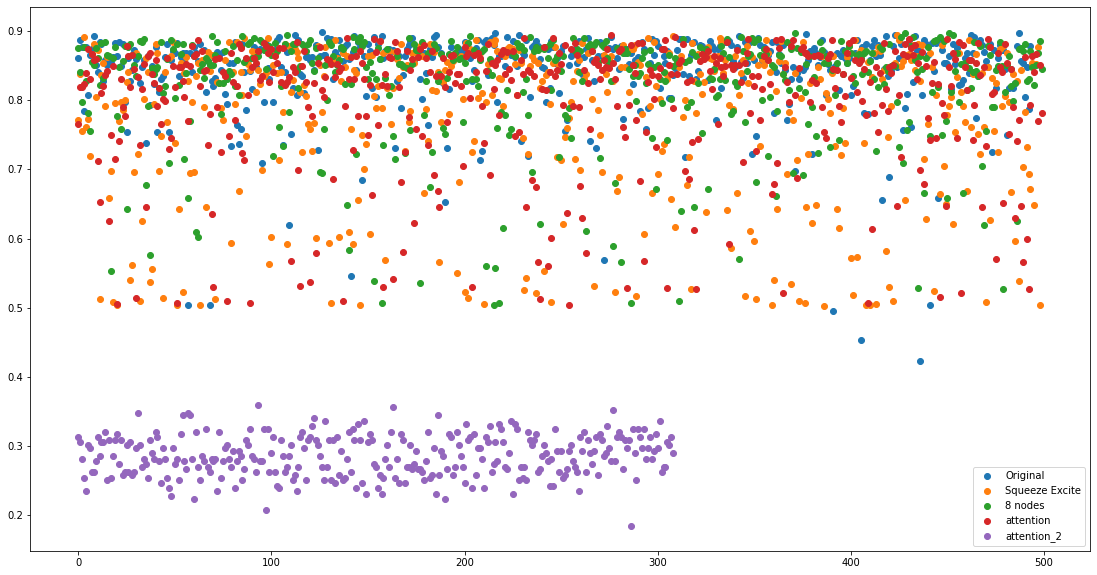

In [105]:
plt.figure(figsize = (19,10))
#plt.ylim(0.05,0.15)
x = np.arange(len(ss_1["scores"]))
plt.scatter(x,ss_1["scores"], label = "Original")
x = np.arange(len(ss_2["scores"]))
plt.scatter(x,ss_2["scores"], label = "Squeeze Excite")
x = np.arange(len(ss_3["scores"]))
plt.scatter(x,ss_3["scores"], label = "8 nodes")
x = np.arange(len(ss_4["scores"]))
plt.scatter(x,ss_4["scores"], label = "attention")
x = np.arange(len(ss_5["scores"]))
plt.scatter(x,ss_5["scores"], label = "attention_2")

#plt.plot(ss_2["scores"], label = "Squeeze Excite")
#plt.plot(ss_3["scores"], label = "8 nodes")
#plt.plot(ss_4["scores"], label = "attention")
plt.legend()

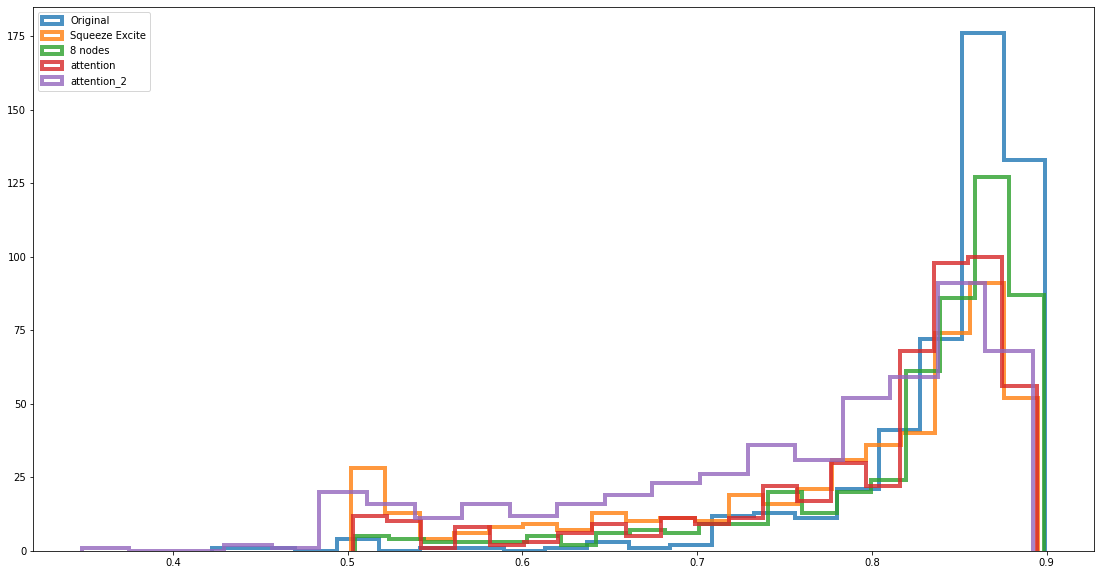

In [189]:
plt.figure(figsize = (19,10))
#plt.ylim(0.05,0.15)

plt.hist(ss_1["scores"],alpha = 0.8,bins = 20 ,label = "Original",histtype = "step",density = False,lw= 4)

plt.hist(ss_2["scores"],alpha = 0.8,bins = 20 , label = "Squeeze Excite",histtype = "step",density = False,lw= 4)

plt.hist(ss_3["scores"],alpha = 0.8, bins = 20 ,label = "8 nodes",histtype = "step",density = False,lw= 4)

plt.hist(ss_4["scores"],alpha = 0.8,bins = 20 , label = "attention",histtype = "step",density = False,lw= 4)

plt.hist(ss_5["scores"],alpha = 0.8, bins = 20 ,label = "attention_2",histtype = "step",density = False,lw= 4)

#plt.plot(ss_2["scores"], label = "Squeeze Excite")
#plt.plot(ss_3["scores"], label = "8 nodes")
#plt.plot(ss_4["scores"], label = "attention")
plt.legend()

In [107]:
bins = np.arange(0.50,1,0.001)

bins

array([0.5  , 0.501, 0.502, 0.503, 0.504, 0.505, 0.506, 0.507, 0.508,
       0.509, 0.51 , 0.511, 0.512, 0.513, 0.514, 0.515, 0.516, 0.517,
       0.518, 0.519, 0.52 , 0.521, 0.522, 0.523, 0.524, 0.525, 0.526,
       0.527, 0.528, 0.529, 0.53 , 0.531, 0.532, 0.533, 0.534, 0.535,
       0.536, 0.537, 0.538, 0.539, 0.54 , 0.541, 0.542, 0.543, 0.544,
       0.545, 0.546, 0.547, 0.548, 0.549, 0.55 , 0.551, 0.552, 0.553,
       0.554, 0.555, 0.556, 0.557, 0.558, 0.559, 0.56 , 0.561, 0.562,
       0.563, 0.564, 0.565, 0.566, 0.567, 0.568, 0.569, 0.57 , 0.571,
       0.572, 0.573, 0.574, 0.575, 0.576, 0.577, 0.578, 0.579, 0.58 ,
       0.581, 0.582, 0.583, 0.584, 0.585, 0.586, 0.587, 0.588, 0.589,
       0.59 , 0.591, 0.592, 0.593, 0.594, 0.595, 0.596, 0.597, 0.598,
       0.599, 0.6  , 0.601, 0.602, 0.603, 0.604, 0.605, 0.606, 0.607,
       0.608, 0.609, 0.61 , 0.611, 0.612, 0.613, 0.614, 0.615, 0.616,
       0.617, 0.618, 0.619, 0.62 , 0.621, 0.622, 0.623, 0.624, 0.625,
       0.626, 0.627,

In [145]:
df = pd.DataFrame(columns = ["BIN",*[ "{}".format(i) for i in set(operations)]])

In [146]:
df["BIN"] = ["{}".format(str(i)[:5]) for i in bins]
df["BIN"] = df["BIN"].astype(str)
df = df.fillna(0)

In [212]:
df_freq = pd.DataFrame(columns = ["op","score"])
def add_counts(ss):
    ops = []
    scores = []
    for s,i in zip(ss["scores"],ss["config"]):
        for op in i:
            if type(i[op]) == str:
                ops.append(i[op])
                scores.append(s)
    df_temp = pd.DataFrame(columns = ["op","score"])
    df_temp["op"] = ops
    df_temp["score"] = scores
    return df_temp
df_freq = df_freq.append(add_counts(ss_1))
df_freq.groupby("op").mean().sort_values(by = "score",ascending = False)
#fig = plt.figure(figsize = (30,20))

,score
op,
avg_pool_31x31,0.846760
skip_connect,0.845717
avg_pool_3x3,0.844522
depth_conv_61,0.844229
max_pool_3x3,0.843212
depth_conv_29,0.842871
none,0.842651
depth_conv_15,0.842211
depth_conv_101,0.840733


In [205]:
df_freq = df_freq.append(add_counts(ss_1))

df_freq = df_freq.append(add_counts(ss_2))
df_freq.groupby("op").mean()
df_freq = df_freq.append(add_counts(ss_3))
df_freq.groupby("op").mean()
df_freq = df_freq.append(add_counts(ss_4))
df_freq.groupby("op").mean()
df_freq = df_freq.append(add_counts(ss_5))
df_freq.groupby("op").mean()


,score
op,
SE_16,0.776719
SE_8,0.821416
attention,0.797001
attention_channel,0.744025
attention_space,0.742174
avg_pool_31x31,0.821389
avg_pool_3x3,0.803015
depth_conv_101,0.818122
depth_conv_15,0.802027


In [200]:
sns.histplot(data = df_freq, x= "score",hue = "op",kde = True,legend = True,stat = "density",fill = False)

<AxesSubplot:xlabel='score', ylabel='Density'>

Error in callback <function flush_figures at 0x7f11cac8d820> (for post_execute):


KeyboardInterrupt: 

In [199]:
df_freq = pd.DataFrame(columns = ["op","score"])
def add_counts(ss):
    ops = []
    scores = []
    for s,i in zip(ss["scores"],ss["config"]):
        for op in i:
            if type(i[op]) == str:
                ops.append(i[op])
                scores.append(s)
    df_temp = pd.DataFrame(columns = ["op","score"])
    df_temp["op"] = ops
    df_temp["score"] = scores
    return df_temp
df_freq = df_freq.append(add_counts(ss_5))
df_freq.groupby("op").mean()

,score
op,
attention_channel,0.744025
attention_space,0.742174
avg_pool_3x3,0.762317
depth_conv_15,0.760398
depth_conv_7,0.757592
max_pool_3x3,0.753271
none,0.760751
point_conv,0.759960
skip_connect,0.757861


,score
op,
attention_channel,0.744025
attention_space,0.742174
avg_pool_3x3,0.762317
depth_conv_15,0.760398
depth_conv_7,0.757592
max_pool_3x3,0.753271
none,0.760751
point_conv,0.759960
skip_connect,0.757861


<AxesSubplot:xlabel='score', ylabel='Density'>

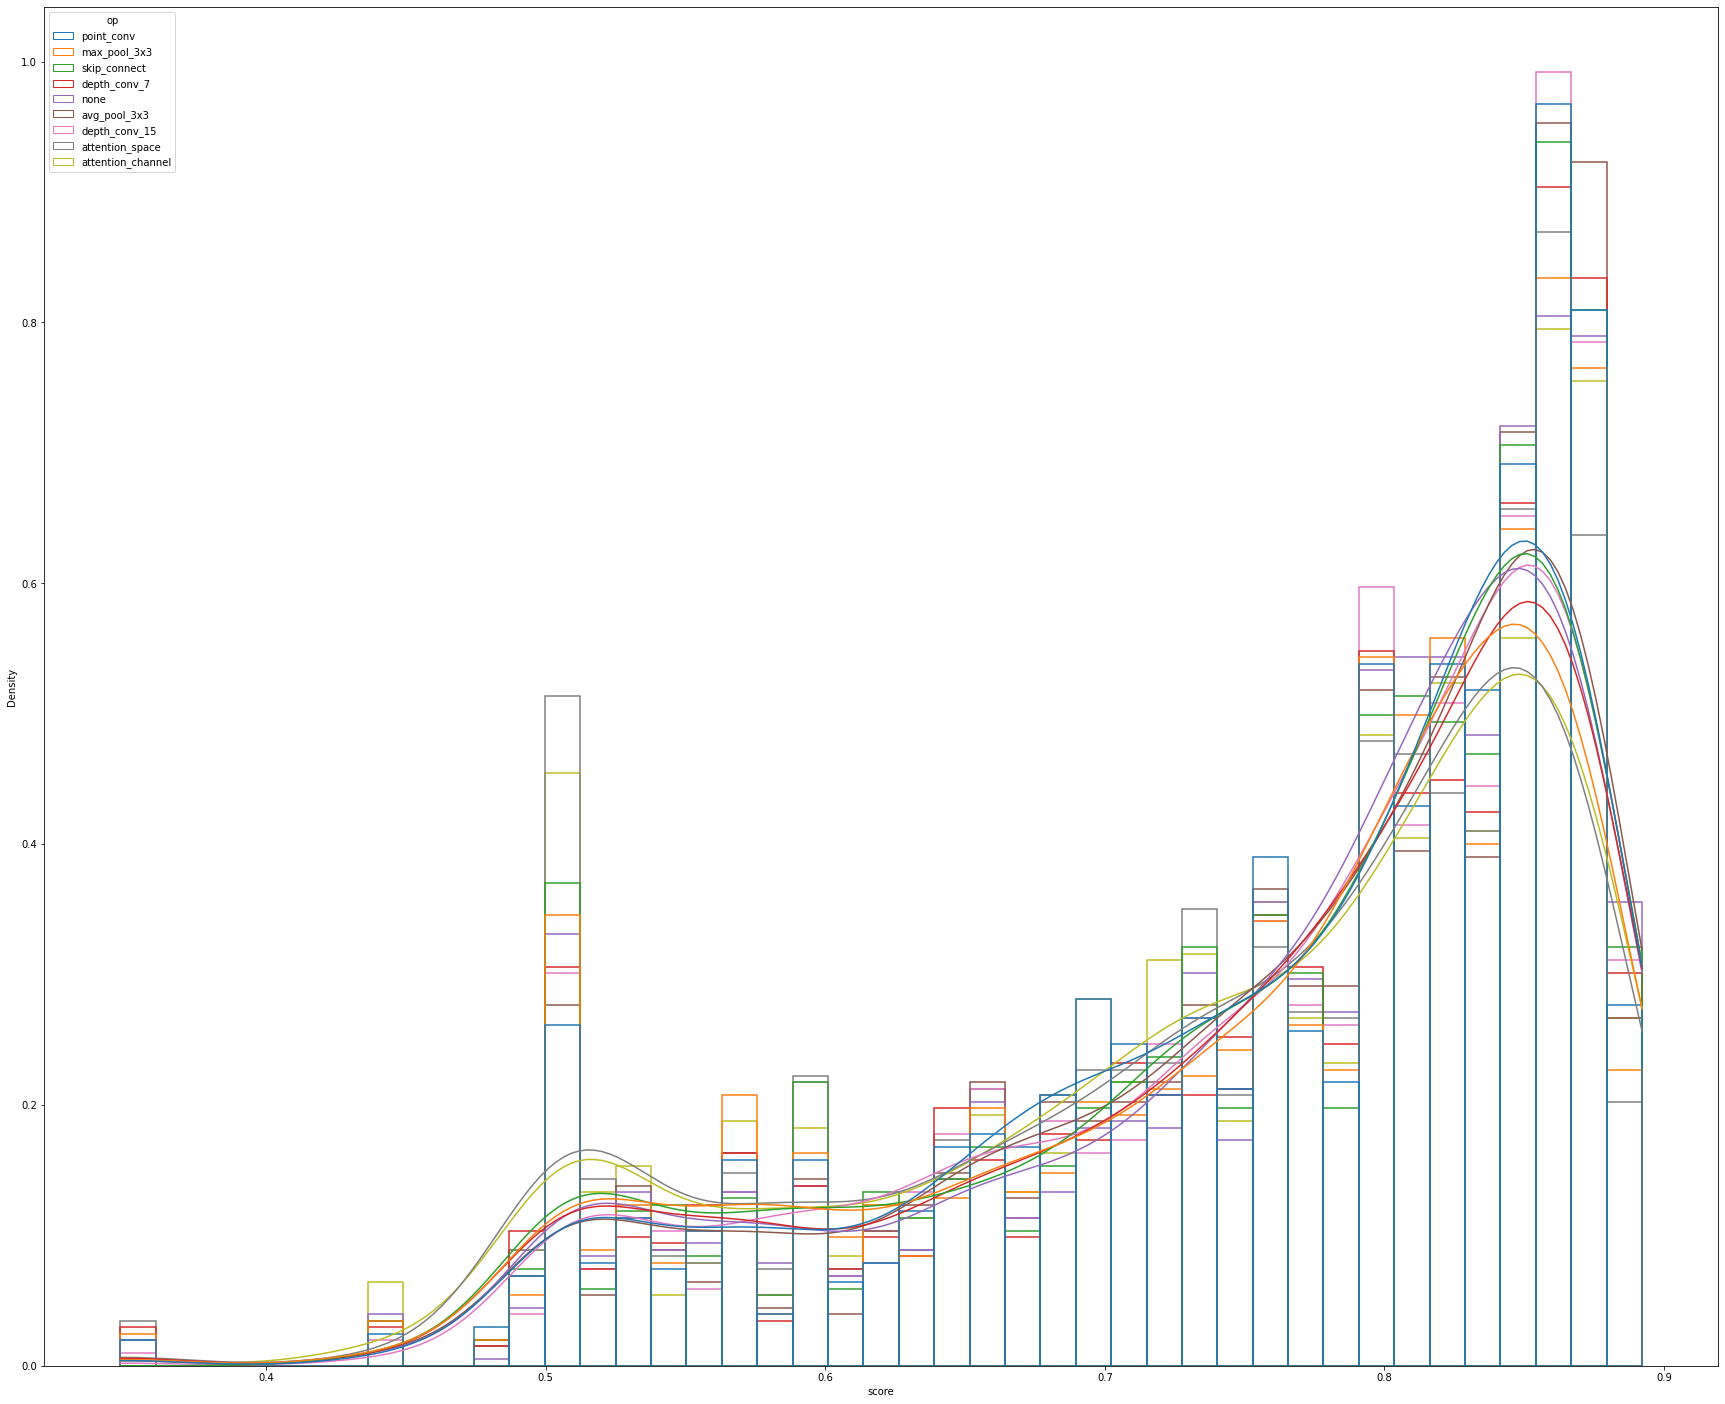

In [190]:
fig = plt.figure(figsize = (30,25))
sns.histplot(data = df_freq, x= "score",hue = "op",kde = True,legend = True,stat = "density",fill = False)

In [224]:
df_freq = pd.DataFrame(columns = ["op","score"])
def add_counts(ss):
    ops = []
    scores = []
    for s,i in zip(ss["scores"],ss["config"]):
        for op in i:
            if type(i[op]) == str:
                ops.append(i[op])
                scores.append(s)
    df_temp = pd.DataFrame(columns = ["op","score"])
    df_temp["op"] = ops
    df_temp["score"] = scores
    return df_temp
df_freq = df_freq.append(add_counts(ss_5))
df_freq.groupby("op").mean().sort_values(by = "score",ascending = False)

,score
op,
avg_pool_3x3,0.762317
none,0.760751
depth_conv_15,0.760398
point_conv,0.759960
skip_connect,0.757861
depth_conv_7,0.757592
max_pool_3x3,0.753271
attention_channel,0.744025
attention_space,0.742174


<AxesSubplot:xlabel='score', ylabel='Density'>

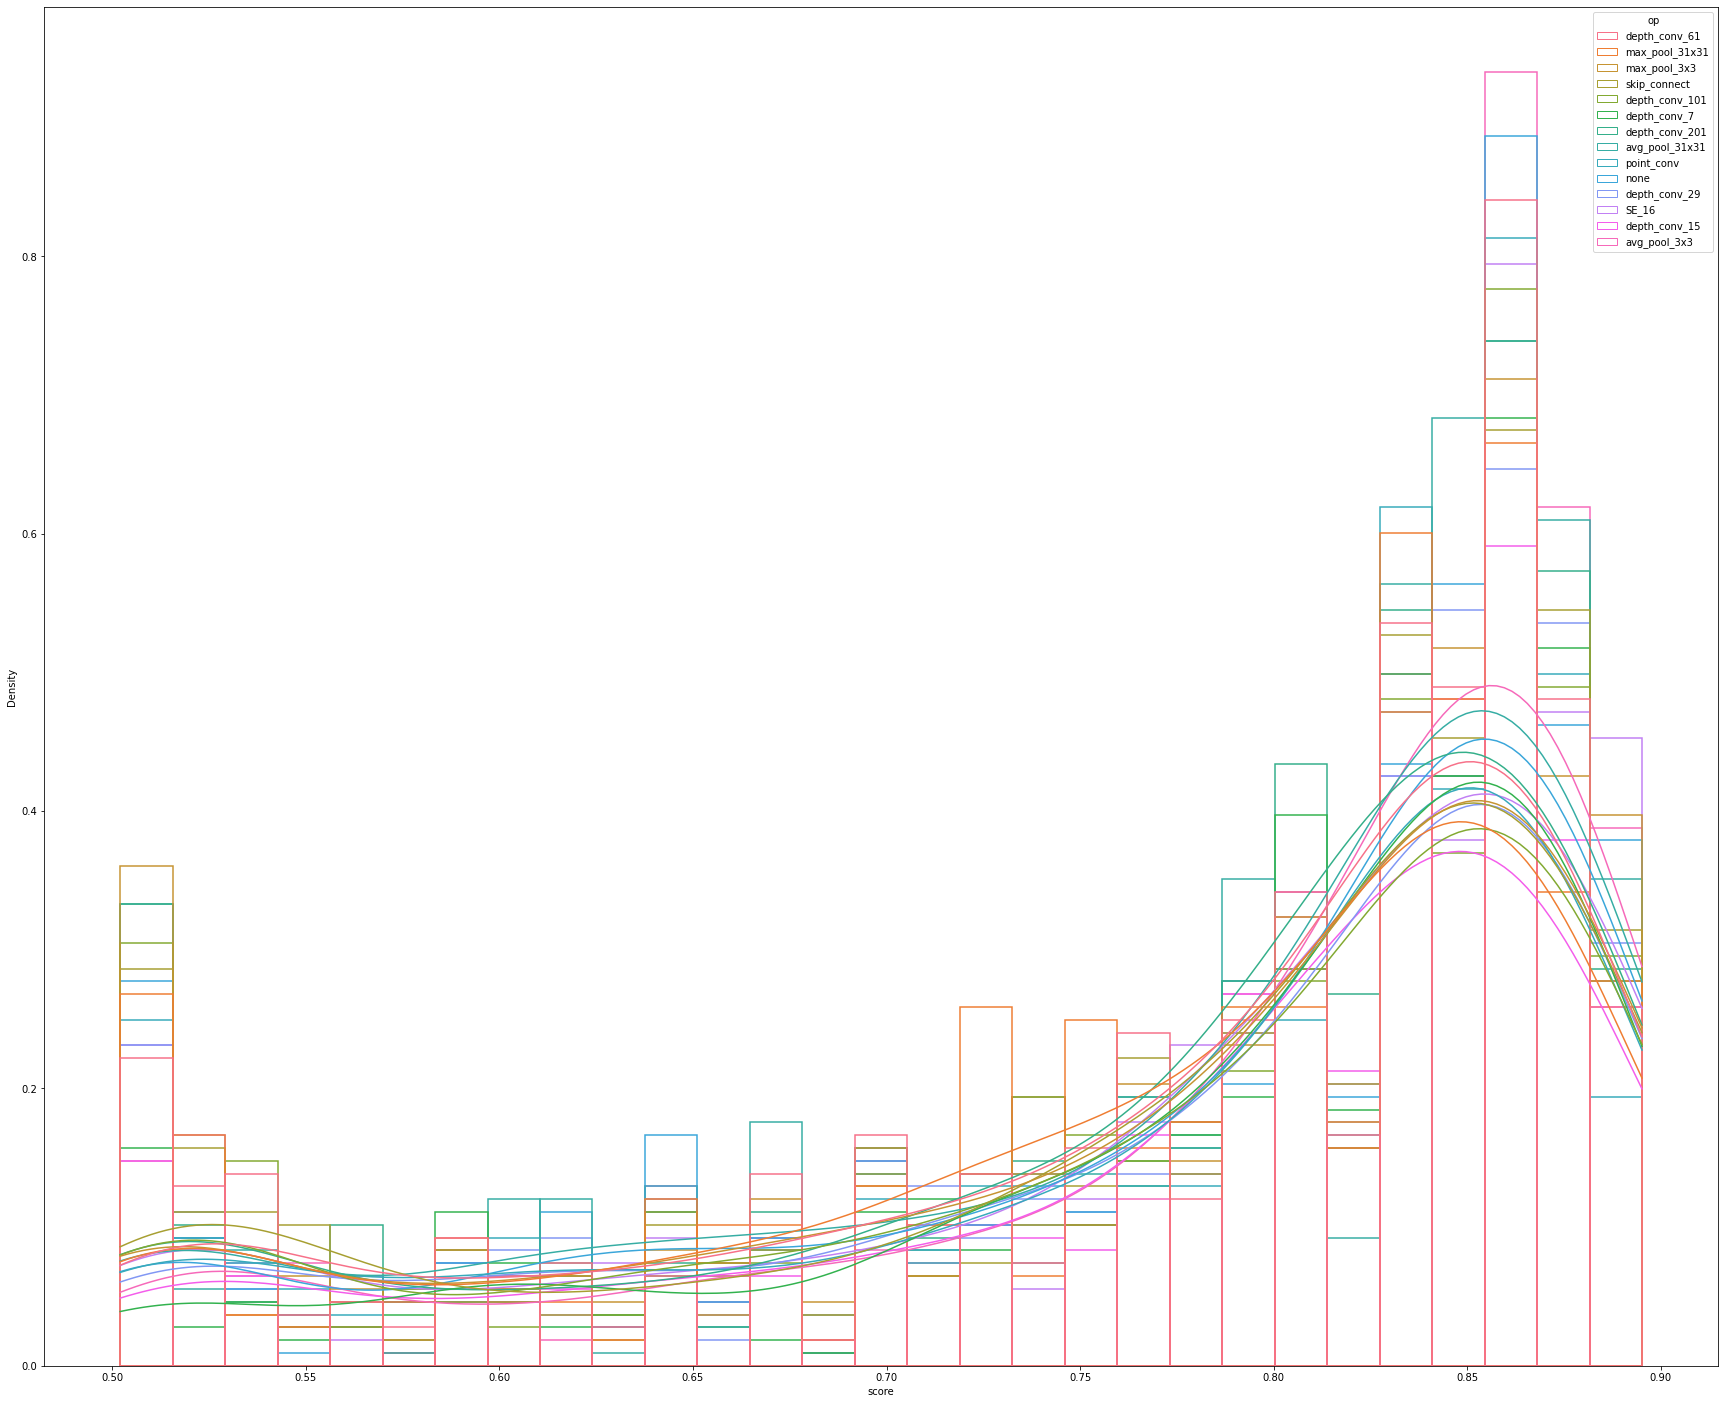

In [219]:
sns.set_palette(sns.color_palette("tab10"))
fig = plt.figure(figsize = (30,25))
df_freq.groupby("op").mean()
sns.histplot(data = df_freq, x= "score",hue = "op",kde = True,legend = True,stat = "density",fill = False)

In [150]:
df_long = pd.melt(df,id_vars = "BIN")
df_long["BIN"] = df_long["BIN"].astype(float)
df_long["BIN"] = df_long["BIN"].astype(float)
df_long["value"] = df_long["value"].astype(int)

In [131]:
fig = plt.figure()
for i in set(operations):
    sub = long_df[long_df["variable"] == i]
    x = sub["BIN"].astype(float)
    y = sub["value"].astype(int)
    #y = [Y for _, Y in sorted(zip(x, y))]
    x = sorted(x)
    #print(x)

In [166]:
df

,BIN,avg_pool_31x31,depth_conv_201,depth_conv_7,max_pool_31x31,depth_conv_101,depth_conv_61,depth_conv_15,max_pool_3x3,skip_connect,avg_pool_3x3,none,depth_conv_29,point_conv
0,0.5,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.501,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.502,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.503,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.504,4,10,7,7,11,2,6,3,8,4,4,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.995,0,0,0,0,0,0,0,0,0,0,0,0,0
496,0.996,0,0,0,0,0,0,0,0,0,0,0,0,0
497,0.997,0,0,0,0,0,0,0,0,0,0,0,0,0
498,0.998,0,0,0,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='BIN', ylabel='value'>

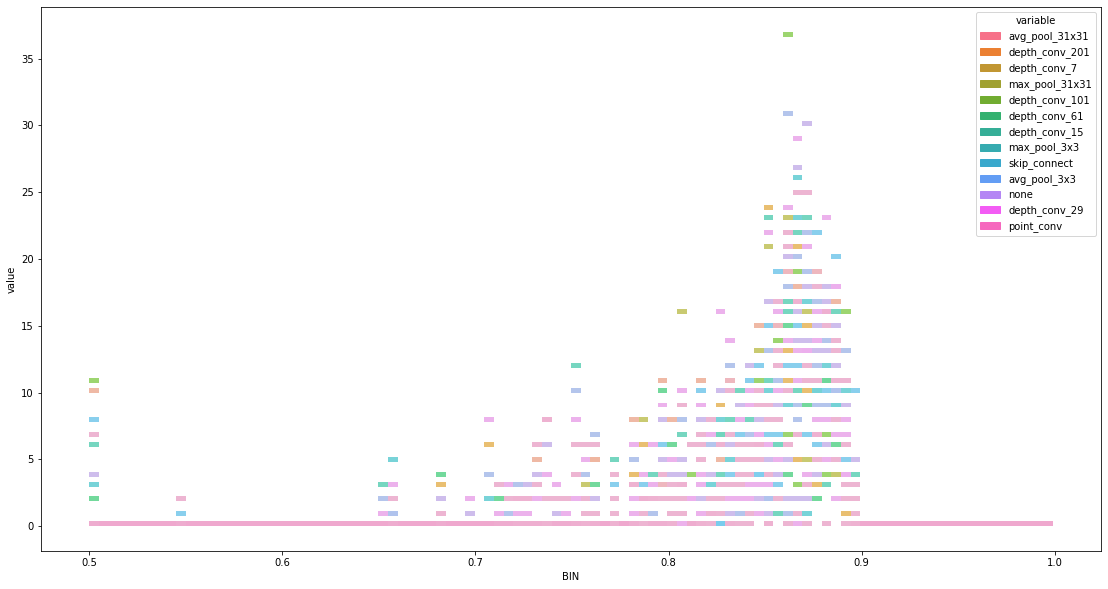

In [165]:

fig = plt.figure(figsize = (19,10))
sns.histplot(data = df_long, x= "BIN",y="value",hue = "variable",kde = True,legend = True,stat = "density",bins = 100 )

In [66]:
df.loc[df.BIN == "0.999","none"] += 1

In [143]:
df["none"].sum()

0

In [148]:
#operations = []

def add_counts(df,ss):
    for s,i in zip(ss["scores"],ss["config"]):
        for op in i:
            if type(i[op]) == str:
                #df[i[op]][df["BIN"] == round(s,3)] += 1
                #print(str(round(s,3)), i[op])
                df.loc[df.BIN == str(round(s,3)),i[op]] += 1 
    
    

In [61]:
operations = []
for i in ss_1["config"]:
        for op in i:
            if type(i[op]) == str:
               operations.append(i[op])
set(operations)

{'avg_pool_31x31',
 'avg_pool_3x3',
 'depth_conv_101',
 'depth_conv_15',
 'depth_conv_201',
 'depth_conv_29',
 'depth_conv_61',
 'depth_conv_7',
 'max_pool_31x31',
 'max_pool_3x3',
 'none',
 'point_conv',
 'skip_connect'}

In [149]:
add_counts(df,ss_1)

In [97]:
def p_res(res):
    scores = res["scores"]
    configs = res["config"]
    for i in range(3):
        idx_max = scores.index(max(scores))
        print("Rank {} score: {}".format(i,scores.pop(idx_max)))
        print("Config: ", configs.pop(idx_max))
        print("\n\n")
p_res(ss_1)
p_res(ss_2)
p_res(ss_3)
p_res(ss_4)
p_res(ss_5)

Rank 0 score: 0.8991935483870968
Config:  {'layers': 5, 'normal_index_0_0': 0, 'normal_index_0_1': 0, 'normal_index_1_0': 0, 'normal_index_1_1': 0, 'normal_index_2_0': 0, 'normal_index_2_1': 0, 'normal_index_3_0': 2, 'normal_index_3_1': 0, 'normal_node_0_0': 'depth_conv_29', 'normal_node_0_1': 'depth_conv_201', 'normal_node_1_0': 'skip_connect', 'normal_node_1_1': 'depth_conv_15', 'normal_node_2_0': 'avg_pool_31x31', 'normal_node_2_1': 'depth_conv_29', 'normal_node_3_0': 'none', 'normal_node_3_1': 'depth_conv_15', 'reduction_index_0_0': 1, 'reduction_index_0_1': 1, 'reduction_index_1_0': 1, 'reduction_index_1_1': 0, 'reduction_index_2_0': 1, 'reduction_index_2_1': 3, 'reduction_index_3_0': 2, 'reduction_index_3_1': 0, 'reduction_node_0_0': 'skip_connect', 'reduction_node_0_1': 'depth_conv_29', 'reduction_node_1_0': 'max_pool_3x3', 'reduction_node_1_1': 'avg_pool_3x3', 'reduction_node_2_0': 'skip_connect', 'reduction_node_2_1': 'depth_conv_15', 'reduction_node_3_0': 'depth_conv_201', 'r

In [8]:
for i in range(10):
    idx_max = scores2.index(max(scores2))
    print("Rank {} score: {}".format(i,scores2.pop(idx_max)))
    print("Config: ", configs2.pop(idx_max))
    print("\n\n")

Rank 0 score: 0.8951612903225806
Config:  {'layers': 7, 'normal_index_0_0': 1, 'normal_index_0_1': 0, 'normal_index_1_0': 2, 'normal_index_1_1': 2, 'normal_index_2_0': 2, 'normal_index_2_1': 0, 'normal_index_3_0': 4, 'normal_index_3_1': 3, 'normal_node_0_0': 'max_pool_3x3', 'normal_node_0_1': 'skip_connect', 'normal_node_1_0': 'depth_conv_201', 'normal_node_1_1': 'depth_conv_29', 'normal_node_2_0': 'avg_pool_31x31', 'normal_node_2_1': 'depth_conv_29', 'normal_node_3_0': 'avg_pool_3x3', 'normal_node_3_1': 'none', 'reduction_index_0_0': 0, 'reduction_index_0_1': 0, 'reduction_index_1_0': 1, 'reduction_index_1_1': 0, 'reduction_index_2_0': 2, 'reduction_index_2_1': 0, 'reduction_index_3_0': 2, 'reduction_index_3_1': 2, 'reduction_node_0_0': 'depth_conv_101', 'reduction_node_0_1': 'SE_16', 'reduction_node_1_0': 'depth_conv_101', 'reduction_node_1_1': 'depth_conv_7', 'reduction_node_2_0': 'depth_conv_15', 'reduction_node_2_1': 'avg_pool_31x31', 'reduction_node_3_0': 'depth_conv_101', 'reduc

In [ ]:
Genotype(normal=[('depth_conv_101', 1), ('max_pool_3x3', 0), ('depth_conv_61', 0), ('max_pool_3x3', 2), ('avg_pool_3x3', 3), ('avg_pool_3x3', 2), 
                 ('avg_pool_3x3', 4), ('depth_conv_15', 1)], normal_concat=range(2, 6), 
                 reduce=[('avg_pool_3x3', 1), ('max_pool_3x3', 0), ('avg_pool_3x3', 2), ('avg_pool_3x3', 1), ('avg_pool_3x3', 2), ('avg_pool_3x3', 1), 
                ('skip_connect', 4), ('avg_pool_3x3', 2)], reduce_concat=range(2, 6)
         
         
Genotype(normal=[('depth_conv_101', 1), ('max_pool_3x3', 0), ('depth_conv_61', 0), ('avg_pool_3x3', 2), ('avg_pool_3x3', 3), ('depth_conv_29', 0), 
                 ('depth_conv_15', 1), ('avg_pool_3x3', 4)], normal_concat=range(2, 6), 
                 reduce=[('avg_pool_3x3', 1), ('max_pool_3x3', 0), ('avg_pool_3x3', 2), ('avg_pool_3x3', 1), ('avg_pool_3x3', 2), ('avg_pool_3x3', 1), 
                ('skip_connect', 4), ('avg_pool_3x3', 2)], reduce_concat=range(2, 6))
